In [1]:
import torch
from torch.distributions import Transform, constraints
from torch.distributions.transforms import SigmoidTransform, AffineTransform, ComposeTransform

In [2]:
class InverseLogUniformBijector(Transform):
    domain = constraints.positive
    codomain = constraints.unit_interval

    def __init__(self, low, high):
        super().__init__()
        self.low = low
        self.high = high

    def __call__(self, y):
        log_y = torch.log(y)
        return (log_y - self.low) / (self.high - self.low)

    def _inverse(self, x):
        log_scaled = x * (self.high - self.low) + self.low
        return torch.exp(log_scaled)

    def log_abs_det_jacobian(self, y, x):
        # For inverse transformation: x = (log(y) - low) / (high - low)
        return -torch.log(y * (self.high - self.low))

class LogUniformBijectorTorch(Transform):
    domain = constraints.unit_interval
    codomain = constraints.positive

    def __init__(self, low=1e-4, high=1e2):
        super().__init__()
        self.low = torch.log(torch.tensor(low).float())
        self.high = torch.log(torch.tensor(high).float())

    def __call__(self, x):
        log_scaled = x * (self.high - self.low) + self.low
        return torch.exp(log_scaled)

    def _inverse(self, y):
        log_y = torch.log(y)
        return (log_y - self.low) / (self.high - self.low)

    def log_abs_det_jacobian(self, x, y):
        # For forward transformation: y = exp(x * (high - low) + low)
        return (self.high - self.low) + torch.log(x)

    @property
    def inv(self):
        return InverseLogUniformBijector(self.low, self.high)

def theta_transform_and_log_prob_adjustment_torch(shift, scale, low=1e-4, high=1e2):
    scalar_affine_transform = AffineTransform(loc=shift, scale=scale)
    expit_transform = SigmoidTransform()
    log_uniform_transform = LogUniformBijectorTorch(low=low, high=high)
    # chained_transform = ComposeTransform([log_uniform_transform, expit_transform, scalar_affine_transform])
    chained_transform = ComposeTransform([scalar_affine_transform, expit_transform, log_uniform_transform])
    return chained_transform

theta_z_score = theta_transform_and_log_prob_adjustment_torch(0, 1.81, low=1e-4, high=1e2)


In [3]:
def transform_posterior_samples_and_adjust_logprobs(post_samples, post_logprobs, shift, scale, low=1e-4, high=1e2):
    """
    Transforms posterior samples and adjusts their corresponding log probabilities using the
    specified transformation (log-uniform with affine and sigmoid components).
    
    Args:
        post_samples (torch.Tensor): Posterior samples in the Gaussian state (shape: [N, D]).
        post_logprobs (torch.Tensor): Log probabilities corresponding to the posterior samples (shape: [N]).
        shift (torch.Tensor): Shift parameter for the affine transform (shape: [D]).
        scale (torch.Tensor): Scale parameter for the affine transform (shape: [D]).
        low (float): Lower bound for the log-uniform transform.
        high (float): Upper bound for the log-uniform transform.
    
    Returns:
        transformed_samples (torch.Tensor): Transformed posterior samples in the log-uniform state (shape: [N, D]).
        transformed_logprobs (torch.Tensor): Adjusted log probabilities in the log-uniform state (shape: [N]).
    """
    # Define the transformation chain
    chained_transform = theta_transform_and_log_prob_adjustment_torch(shift, scale, low, high)

    # Transform the samples
    transformed_samples = chained_transform(post_samples)

    # Compute the log-determinant Jacobian of the transformation
    log_det_jacobian = chained_transform.log_abs_det_jacobian(post_samples, transformed_samples)

    # Ensure log_det_jacobian is 1D and matches post_logprobs
    if log_det_jacobian.dim() > 1:
        log_det_jacobian = log_det_jacobian.sum(dim=-1) 

    # Adjust the log probabilities
    transformed_logprobs = post_logprobs - log_det_jacobian

    return transformed_samples, transformed_logprobs


In [4]:
post_lps_samples_all = torch.load('posterior_lps/post_lps_all_3_seeds.pth', map_location=torch.device('cpu'))
post_lps_samples_0 = torch.load('posterior_lps/post_lps_0_3_seeds.pth', map_location=torch.device('cpu'))
post_lps_samples_1 = torch.load('posterior_lps/post_lps_1_3_seeds.pth', map_location=torch.device('cpu'))
post_lps_samples_2 = torch.load('posterior_lps/post_lps_2_3_seeds.pth', map_location=torch.device('cpu'))
post_lps_samples_3 = torch.load('posterior_lps/post_lps_3_3_seeds.pth', map_location=torch.device('cpu'))

In [5]:
# Define the identities
ligands = {
    'L_1': 'BMP4',
    'L_2': 'BMP7',
    'L_3': 'BMP9',
    'L_4': 'BMP10',
    'L_5': 'GDF5'
}

type_i_rec = ['ACVR1', 'BMPR1A']  # A_1, A_2
type_ii_rec = ['ACVR2A', 'ACVR2B', 'BMPR2']  # B_1, B_2, B_3

# Initialize the mapping dictionary
t_mappings = {}

# Generate mappings for all T values
for l_num in range(1, 6):  # L_1 to L_5
    ligand = ligands[f'L_{l_num}']
    for i in range(1, 3):  # First index (1 or 2)
        type_i = type_i_rec[i-1]
        for j in range(1, 4):  # Second index (1, 2, or 3)
            type_ii = type_ii_rec[j-1]
            
            # Create the T key (e.g., T_1_1_1)
            t_key = f'K_{l_num}_{i}_{j}'
            
            # Create the concatenated value (e.g., BMP4-ACVR1-ACVR2A)
            t_value = f'{ligand}-{type_i}-{type_ii}'
            
            # Add to dictionary
            t_mappings[t_key] = t_value

# Print all mappings in order
for t_key in sorted(t_mappings.keys()):
    print(f"'{t_key}': '{t_mappings[t_key]}'")

# For generating E values with the same pattern
e_mappings = {f'e_{key[2:]}': value for key, value in t_mappings.items()}

# Print E mappings
# print("\nE mappings:")
for e_key in sorted(e_mappings.keys()):
    print(f"'{e_key}': '{e_mappings[e_key]}'")

# Combine both dictionaries if needed
combined_mappings = {**t_mappings, **e_mappings}

'K_1_1_1': 'BMP4-ACVR1-ACVR2A'
'K_1_1_2': 'BMP4-ACVR1-ACVR2B'
'K_1_1_3': 'BMP4-ACVR1-BMPR2'
'K_1_2_1': 'BMP4-BMPR1A-ACVR2A'
'K_1_2_2': 'BMP4-BMPR1A-ACVR2B'
'K_1_2_3': 'BMP4-BMPR1A-BMPR2'
'K_2_1_1': 'BMP7-ACVR1-ACVR2A'
'K_2_1_2': 'BMP7-ACVR1-ACVR2B'
'K_2_1_3': 'BMP7-ACVR1-BMPR2'
'K_2_2_1': 'BMP7-BMPR1A-ACVR2A'
'K_2_2_2': 'BMP7-BMPR1A-ACVR2B'
'K_2_2_3': 'BMP7-BMPR1A-BMPR2'
'K_3_1_1': 'BMP9-ACVR1-ACVR2A'
'K_3_1_2': 'BMP9-ACVR1-ACVR2B'
'K_3_1_3': 'BMP9-ACVR1-BMPR2'
'K_3_2_1': 'BMP9-BMPR1A-ACVR2A'
'K_3_2_2': 'BMP9-BMPR1A-ACVR2B'
'K_3_2_3': 'BMP9-BMPR1A-BMPR2'
'K_4_1_1': 'BMP10-ACVR1-ACVR2A'
'K_4_1_2': 'BMP10-ACVR1-ACVR2B'
'K_4_1_3': 'BMP10-ACVR1-BMPR2'
'K_4_2_1': 'BMP10-BMPR1A-ACVR2A'
'K_4_2_2': 'BMP10-BMPR1A-ACVR2B'
'K_4_2_3': 'BMP10-BMPR1A-BMPR2'
'K_5_1_1': 'GDF5-ACVR1-ACVR2A'
'K_5_1_2': 'GDF5-ACVR1-ACVR2B'
'K_5_1_3': 'GDF5-ACVR1-BMPR2'
'K_5_2_1': 'GDF5-BMPR1A-ACVR2A'
'K_5_2_2': 'GDF5-BMPR1A-ACVR2B'
'K_5_2_3': 'GDF5-BMPR1A-BMPR2'

E mappings:
'e_1_1_1': 'BMP4-ACVR1-ACVR2A'
'e_1_1_2': 'BMP

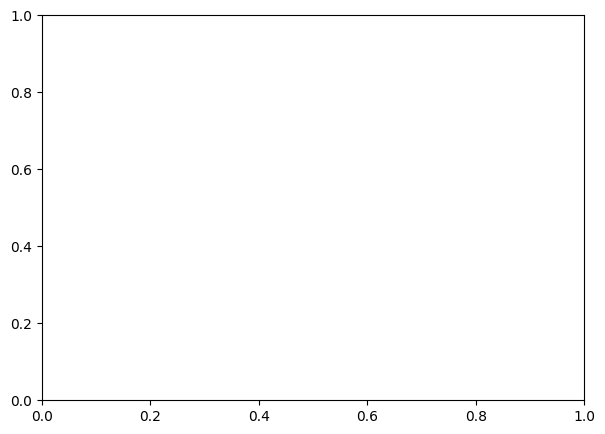

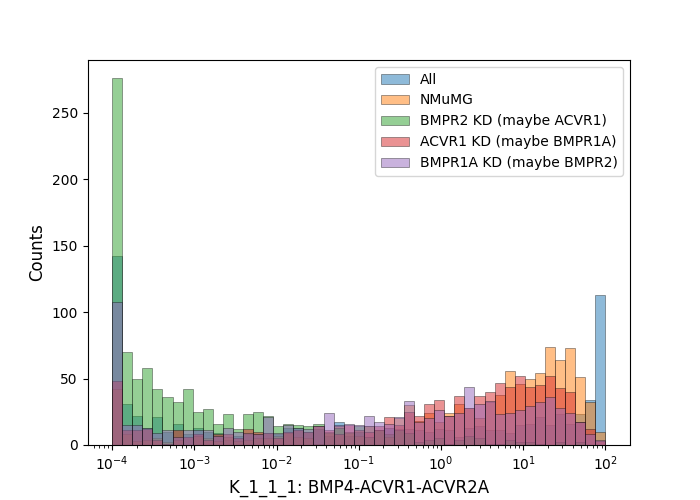

In [6]:
%matplotlib widget
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets

################################################################################
# 1) Load all of your datasets (same as before):
post_lps_samples_all = torch.load('posterior_lps/post_lps_all_3_seeds.pth', map_location=torch.device('cpu'))
post_lps_samples_0   = torch.load('posterior_lps/post_lps_0_3_seeds.pth',   map_location=torch.device('cpu'))
post_lps_samples_1   = torch.load('posterior_lps/post_lps_1_3_seeds.pth',   map_location=torch.device('cpu'))
post_lps_samples_2   = torch.load('posterior_lps/post_lps_2_3_seeds.pth',   map_location=torch.device('cpu'))
post_lps_samples_3   = torch.load('posterior_lps/post_lps_3_3_seeds.pth',   map_location=torch.device('cpu'))

################################################################################
# 2) For convenience, define a dictionary mapping dataset name -> data.
datasets = {
    'All': post_lps_samples_all['seeds_data'][0],  
    'NMuMG':   post_lps_samples_0['seeds_data'][0],
    'BMPR2 KD (maybe ACVR1)':   post_lps_samples_1['seeds_data'][0],
    'ACVR1 KD (maybe BMPR1A)':   post_lps_samples_2['seeds_data'][0],
    'BMPR1A KD (maybe BMPR2)':   post_lps_samples_3['seeds_data'][0],
}

################################################################################
# 3) Apply z-scoring and store references.
for k, v in datasets.items():
    raw_samples = v['post_samples']       # shape (N, 60), etc.
    v['zscored'] = theta_z_score(raw_samples)
    v['logprobs'] = v['posterior_logprobs']

num_dims = datasets['All']['zscored'].shape[1]

################################################################################
# 4) Create a single figure and axes for the interactive histogram.
fig, ax = plt.subplots(figsize=(7, 5))

bins = np.logspace(np.log10(1e-4), np.log10(1e2 + 1e-1), 50)
current_dim = 0

################################################################################
# 5) Create a set of checkboxes, one for each dataset key, defaulting to True.
checkboxes = {
    ds_name: widgets.Checkbox(
        value=True,
        description=ds_name,
        indent=False
    )
    for ds_name in datasets.keys()
}

def get_selected_datasets():
    """Return a list of dataset names that are currently checked."""
    return [k for k, cb in checkboxes.items() if cb.value]

################################################################################
def update_plot(dim):
    """
    Clear and redraw the histogram for dimension `dim`, 
    only for the datasets that are selected (checkbox = True).
    """
    ax.clear()

    # Determine if this is a T or E dimension and get the corresponding key
    is_t = dim < 30
    idx = dim if is_t else dim - 30
    key = f"{'K' if is_t else 'e'}_{(idx//6)+1}_{((idx%6)//3)+1}_{(idx%3)+1}"
    label = combined_mappings[key]

    colors = ['C0', 'C1', 'C2', 'C3', 'C4']  # define colors or pick your own
    selected = get_selected_datasets()
    
    # Plot only those datasets whose checkbox is checked
    for (ds_name, ds_data), color in zip(datasets.items(), colors):
        if ds_name in selected:
            dim_samples = ds_data['zscored'][:, dim].numpy()
            ax.hist(dim_samples, bins=bins, alpha=0.5, color=color,
                    label=f"{ds_name}", edgecolor='black', linewidth=0.5)

    ax.set_xscale('log')
    ax.set_xlabel(fr"{key}: {label}", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.legend()
    
    fig.canvas.draw_idle()

################################################################################
# 6) Add the interactive dimension-navigation buttons (Prev, Next).
button_prev = widgets.Button(description="Prev Dim")
button_next = widgets.Button(description="Next Dim")
label_dim = widgets.Label(value=f"Dimension: {current_dim}")

def on_prev_clicked(_):
    global current_dim
    current_dim = (current_dim - 1) % num_dims
    label_dim.value = f"Dimension: {current_dim}"
    update_plot(current_dim)

def on_next_clicked(_):
    global current_dim
    current_dim = (current_dim + 1) % num_dims
    label_dim.value = f"Dimension: {current_dim}"
    update_plot(current_dim)

button_prev.on_click(on_prev_clicked)
button_next.on_click(on_next_clicked)

################################################################################
# 7) Observe changes to the checkbox values so that whenever one is toggled,
#    the figure updates immediately.
def on_checkbox_change(change):
    if change['name'] == 'value':  # means the checkbox was toggled
        update_plot(current_dim)

for cb in checkboxes.values():
    cb.observe(on_checkbox_change, names='value')

################################################################################
# 8) Display layout: an HBox for dimension navigation and an HBox or VBox for checkboxes.
dim_controls = widgets.HBox([button_prev, label_dim, button_next])
checkbox_controls = widgets.VBox([checkboxes[name] for name in sorted(checkboxes.keys())])

# Show them side by side or in separate cells as you prefer:
display(widgets.HBox([dim_controls, checkbox_controls]))
display(fig)

# Initialize first dimension
update_plot(current_dim)
